In [3]:
options(warn=-1)

library(ellipse)
library(mvtnorm)
library(MASS)

Будемо будувати еліпс, використовуючи рівняння в параметричному виді.

$$\begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} \cos(\phi) & -\sin(\phi) \\ \sin(\phi) & \cos(\phi) \end{bmatrix} \begin{bmatrix} \sqrt\lambda_1\sqrt{Q_{\chi^2}(level)}\cos(t) \\ \sqrt\lambda_2\sqrt{Q_{\chi^2}(level)}\sin(t) \end{bmatrix} + \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}$$

Тут $\lambda_1, \lambda_2$ -- власні числа матриці коваріацій, $\mu_1, \mu_2$ -- компоненти вектора середніх, $\phi$ -- кут між $OX$ і власним вектором, що відповідає найбільшому власному числу, $t \in [0, 2\pi]$.

Відповідно, також збільшуємо довжини осей пропорційно заданому рівню значущості. 

Я використовую $Q_{\chi^2}(level)$ -- квантиль рівня $level$ розподілу $\chi^2$ з двома ступенями свободи.

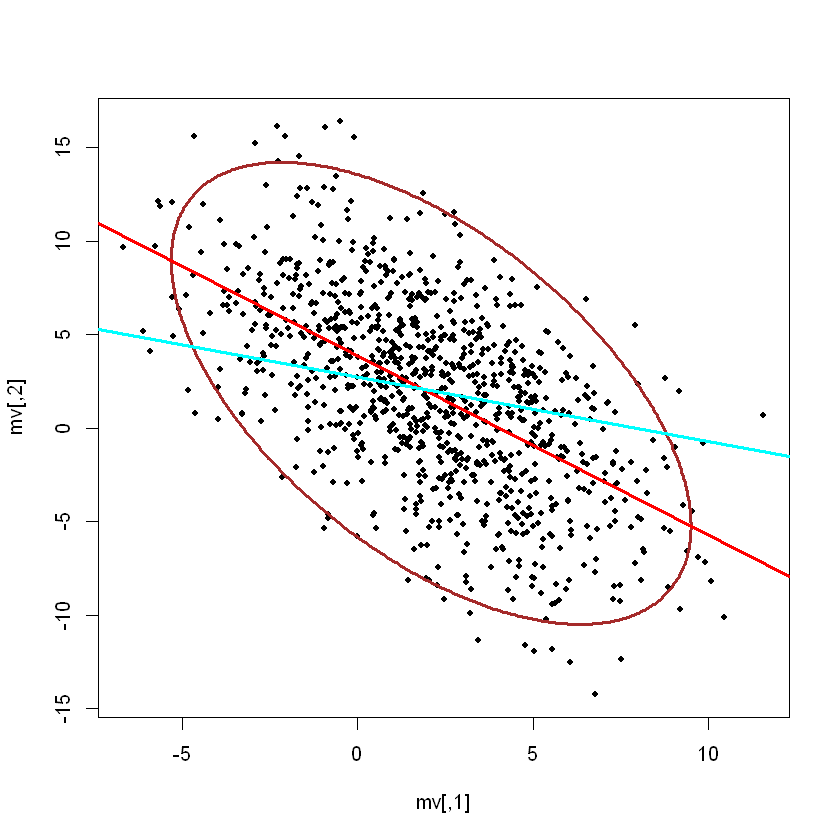

In [2]:
mu <- c(2, 2)
sigma <- c(3, 5)
rho <- -0.6

covariance.true <- matrix(
    c(sigma[1]^2, rho * sigma[1] * sigma[2], rho * sigma[1] * sigma[2], sigma[2]^2),
    nrow=2
)

confidence_ellipse <- function(mv, level){
    
    covariance <- cov(mv)
    mu_1 <- mean(mv[, 1]); mu_2 <- mean(mv[, 2])
    pearson <- covariance[1, 2] / sqrt(covariance[1, 1] * covariance[2, 2])
    
    eigenvalues <- eigen(covariance)$values
    eigenvectors <- eigen(covariance)$vectors
    
    radius_x <- sqrt(eigenvalues[1])
    radius_y <- sqrt(eigenvalues[2])
    
    phi <- atan2(eigenvectors[2, 1], eigenvectors[1, 1])
    t <- seq(0, 2*pi, 0.01)
    
    scale_x <- sqrt(qchisq(level, 2))
    scale_y <- sqrt(qchisq(level, 2))
    
    #parametric ellipse equation
    ell_x <- mu_1 + radius_x * scale_x * cos(t) * cos(phi) - radius_y * scale_y * sin(t) * sin(phi)
    ell_y <- mu_2 + radius_x * scale_x * cos(t) * sin(phi) + radius_y * scale_y * sin(t) * cos(phi)
    
    return(matrix(c(ell_x, ell_y), ncol=2))
}


mv <- rmvnorm(1000, mu, covariance.true)

covariance <- cov(mv)
mu_1 <- mean(mv[, 1]); mu_2 <- mean(mv[, 2])
pearson <- covariance[1, 2] / sqrt(covariance[1, 1] * covariance[2, 2])

ell <- confidence_ellipse(mv, level=0.95)

plot(mv, pch=20)
#lines(ellipse(pearson, level=0.99, center=c(mu_1, mu_2), scale=c(sqrt(covariance[1, 1]), sqrt(covariance[2, 2]))), col="blue")
lines(ell, col="brown", lwd=3)
y_on_x <- lm(mv[ ,2] ~ mv[ ,1])
x_on_y <- lm(mv[ ,1] ~ mv[ ,2])
abline(y_on_x, col="red", lwd = 3)
abline(x_on_y, col="cyan", lwd = 3)

Відповідно, пограючись із цим деякий час, можна сказати, що $\sigma_1, \sigma_2$ відповідають за загальний масштаб еліпса, в той час як $\rho$ -- коефіцієнт кореляції Пірсона -- впливає беспосередньо на видовження осей еліпса. 

При $\rho > 0:$ $\lambda_1 > \lambda_2$, тому еліпс видовжується вздовж власного вектора, який відповідає $\lambda_1$.

При $\rho = 0:$ $\lambda_1 = \lambda_2$, тому еліпс ніяк не видовжується і стає звичайним колом.

При $\rho < 0:$ $\lambda_1 < \lambda_2$, тому еліпс видовжується вздовж власного вектора, що відповідає $\lambda_2$.

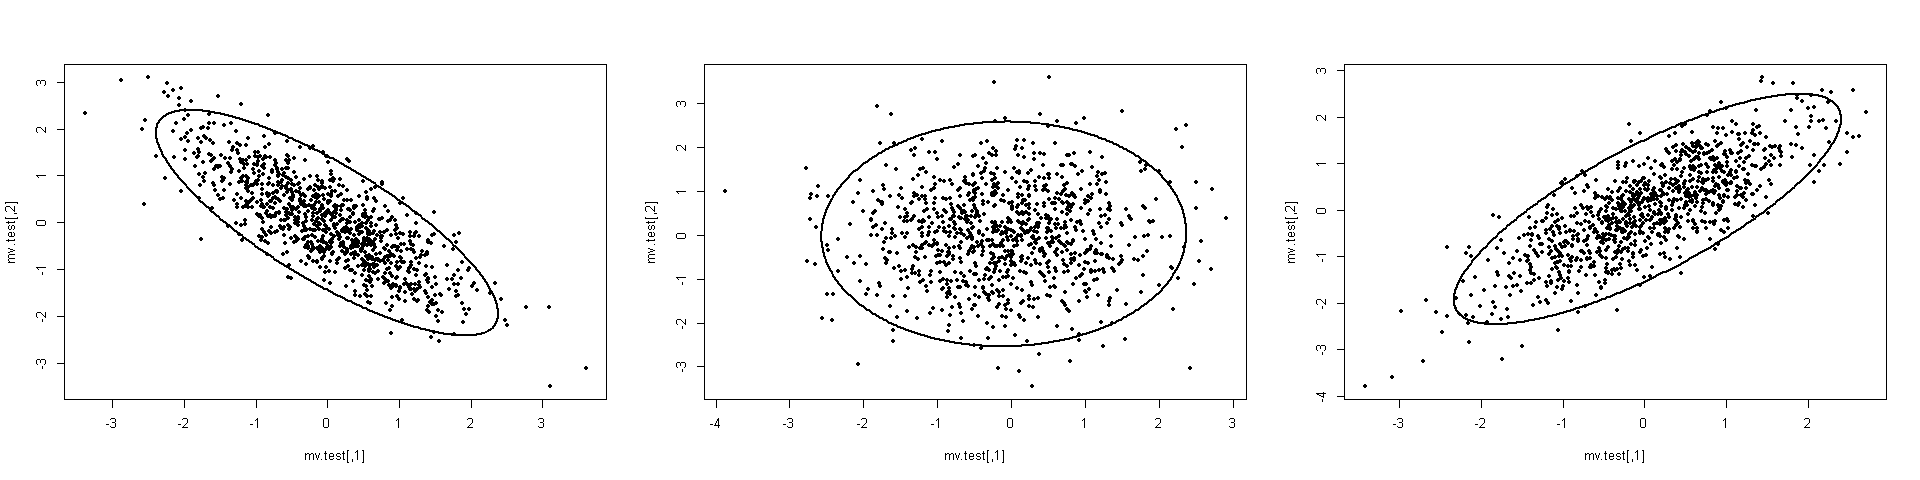

In [4]:
par(mfrow=c(1, 3))
options(repr.plot.width=16, repr.plot.height=4)

rhos <- c(-0.8, 0, 0.8)
mu.test <- c(0, 0)
sigma.test <- c(1, 1)

for (i in rhos){
    covariance.test <- matrix(c(sigma.test[1]^2, i * sigma.test[1] * sigma.test[2], 
                                i * sigma.test[1] * sigma.test[2], sigma.test[2]^2), nrow=2)
    
    mv.test <- rmvnorm(1000, mu.test, covariance.test)
    ell.test <- confidence_ellipse(mv.test, level=0.95)
    
    plot(mv.test, pch=20)
    lines(ell.test, lwd=2)
}